## MNIST dataset

In [28]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [32]:
X, y = mnist['data'], mnist['target']

In [33]:
X.shape

(70000, 784)

In [34]:
type(y)

numpy.ndarray

In [35]:

y.shape

(70000,)

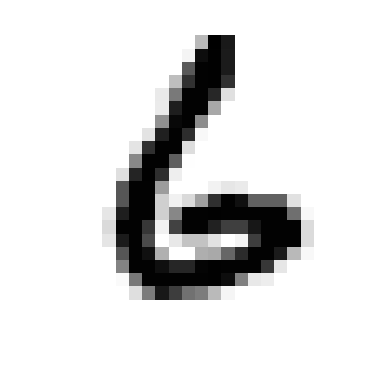

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

some_digit = X[np.random.randint(0,69999)]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [39]:
y = y.astype(np.uint8)

Training set is already shuffled

In [43]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]